In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
#raw_transcripts = pd.read_csv("../data/raw_transcripts.csv", encoding='utf-8')
df = pd.read_csv("../data/comments_posts_transcripts.csv", encoding='utf-8')

df['createTimeISO'] = pd.to_datetime(df['createTimeISO'], utc=True, errors='coerce')

three_months_ago = pd.Timestamp.utcnow() - pd.DateOffset(months=3)
df = df[df['createTimeISO'] >= three_months_ago]

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import re

def comprehensive_post_aggregation(df):
    """
    Advanced aggregation preserving all TikTok content types
    """
    # Group by post_id with comprehensive feature aggregation
    aggregated = df.groupby('post_id').agg({
        # Core post content (preserve first occurrence)
        'text': 'first',
        'transcribed_text': 'first', 
        'video_description': 'first',
        'textLanguage': 'first',
        'createTimeISO': 'first',
        'author_nickName': 'first',
        'author_fans': 'first',
        'video_duration': 'first',
        
        # Engagement metrics
        'diggCount': 'first',
        'shareCount': 'first', 
        'playCount': 'first',
        'collectCount': 'first',
        
        # Hashtag information
        'searchHashtag_name': 'first',
        'searchHashtag_views': 'first',
        
        # Advanced comment aggregation
        'comment': lambda x: ' |COMMENT_SEP| '.join(x.dropna().astype(str)),
        'comment_createTimeISO_comment': ['count', 'first', 'last'],
        'diggCount_comment': ['sum', 'mean', 'max', 'std'],
        'uniqueId_comment': 'nunique',
        'comment_lang': lambda x: list(x.dropna().unique())
    }).reset_index()
    
    # Flatten column names
    aggregated.columns = [
        'post_id', 'text', 'transcribed_text', 'video_description', 
        'textLanguage', 'createTimeISO', 'author_nickName', 'author_fans',
        'video_duration', 'diggCount', 'shareCount', 'playCount', 'collectCount',
        'searchHashtag_name', 'searchHashtag_views', 'all_comments',
        'comment_count', 'first_comment_time', 'last_comment_time',
        'total_comment_likes', 'avg_comment_likes', 'max_comment_likes', 'comment_like_std',
        'unique_commenters', 'comment_languages'
    ]
    
    return aggregated

# Apply aggregation
df_posts = comprehensive_post_aggregation(df)


In [8]:
import nltk


# Download required NLTK data
nltk.download(['punkt', 'stopwords', 'wordnet', 'vader_lexicon'])

def advanced_tiktok_preprocessing(text, handle_slang=True, preserve_emotions=True):
    """
    Enhanced preprocessing for TikTok content with emotion preservation
    """
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to lowercase while preserving emotional indicators
    text = text.lower()
    
    # Handle TikTok-specific patterns
    text = re.sub(r'@\w+', '[USER_MENTION]', text)  # Preserve mention structure
    text = re.sub(r'#(\w+)', r'hashtag_\1', text)   # Convert hashtags to tokens
    text = re.sub(r'http\S+|www\S+', '[URL]', text) # Replace URLs
    
    # Handle repeated characters (sooooo -> so) but preserve emphasis
    text = re.sub(r'(.)\1{3,}', r'\1\1\1', text)    # Max 3 repetitions
    
    # Advanced slang dictionary based on 2024 TikTok trends
    if handle_slang:
        slang_dict = {
            'periodt': 'period', 'slay': 'excellent', 'no cap': 'no lie',
            'bussin': 'excellent', 'sheesh': 'impressive', 'mid': 'mediocre',
            'bet': 'yes', 'fr': 'for real', 'ong': 'on god', 'ngl': 'not gonna lie',
            'lowkey': 'somewhat', 'highkey': 'obviously', 'vibes': 'feelings'
        }
        for slang, replacement in slang_dict.items():
            text = re.sub(r'\b' + slang + r'\b', replacement, text)
    
    # Clean while preserving emotional punctuation
    if preserve_emotions:
        text = re.sub(r'[^\w\s!?.\']', ' ', text)
    else:
        text = re.sub(r'[^\w\s\']', ' ', text)
    
    # Tokenization and lemmatization
    tokens = nltk.word_tokenize(text)
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if len(token) > 1]
    
    return ' '.join(tokens)

# Apply to all text columns
text_columns = ['text', 'transcribed_text', 'video_description', 'all_comments']
for col in text_columns:
    df_posts[f'{col}_processed'] = df_posts[col].apply(advanced_tiktok_preprocessing)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hannahschlaucher/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hannahschlaucher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hannahschlaucher/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hannahschlaucher/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Initialize advanced sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()
emotion_classifier = pipeline("text-classification", 
                             model="j-hartmann/emotion-english-distilroberta-base")

def comprehensive_sentiment_analysis(text):
    """
    Multi-level sentiment and emotion analysis
    """
    if pd.isna(text) or text.strip() == '':
        return {
            'vader_compound': 0, 'vader_pos': 0, 'vader_neu': 1, 'vader_neg': 0,
            'emotion_label': 'neutral', 'emotion_score': 0
        }
    
    # VADER sentiment (optimized for social media)
    vader_scores = vader_analyzer.polarity_scores(text)
    
    # Advanced emotion detection
    try:
        emotions = emotion_classifier(text[:512])  # Limit for transformer
        top_emotion = emotions[0]
        emotion_label = top_emotion['label']
        emotion_score = top_emotion['score']
    except:
        emotion_label = 'neutral'
        emotion_score = 0
    
    return {
        'vader_compound': vader_scores['compound'],
        'vader_pos': vader_scores['pos'],
        'vader_neu': vader_scores['neu'], 
        'vader_neg': vader_scores['neg'],
        'emotion_label': emotion_label,
        'emotion_score': emotion_score
    }

# Apply sentiment analysis to all text types
for col in text_columns:
    sentiment_results = df_posts[f'{col}_processed'].apply(comprehensive_sentiment_analysis)
    
    # Extract sentiment features
    for metric in ['vader_compound', 'vader_pos', 'vader_neu', 'vader_neg', 'emotion_score']:
        df_posts[f'{col}_{metric}'] = sentiment_results.apply(lambda x: x[metric])
    
    df_posts[f'{col}_emotion'] = sentiment_results.apply(lambda x: x['emotion_label'])


tf_model.h5:   0%|          | 0.00/329M [00:00<?, ?B/s]

2025-06-24 20:18:01.661327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0
Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors


In [10]:
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer
import torch

class MultiModalTextEncoder:
    def __init__(self):
        # Initialize multiple transformer models for ensemble approach
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        
        self.roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.roberta_model = RobertaModel.from_pretrained('roberta-base')
        
        # Set models to evaluation mode
        self.bert_model.eval()
        self.roberta_model.eval()
    
    def encode_text_bert(self, texts, max_length=256):
        """Generate BERT embeddings for text batch"""
        embeddings = []
        
        with torch.no_grad():
            for text in texts:
                if pd.isna(text) or text.strip() == '':
                    embeddings.append(np.zeros(768))
                    continue
                
                # Tokenize and encode
                encoded = self.bert_tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,
                    max_length=max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                # Get embeddings
                outputs = self.bert_model(**encoded)
                cls_embedding = outputs.last_hidden_state[0][0].numpy()
                embeddings.append(cls_embedding)
        
        return np.array(embeddings)
    
    def encode_text_roberta(self, texts, max_length=256):
        """Generate RoBERTa embeddings for text batch"""
        embeddings = []
        
        with torch.no_grad():
            for text in texts:
                if pd.isna(text) or text.strip() == '':
                    embeddings.append(np.zeros(768))
                    continue
                
                encoded = self.roberta_tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,
                    max_length=max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                outputs = self.roberta_model(**encoded)
                cls_embedding = outputs.last_hidden_state[0][0].numpy()
                embeddings.append(cls_embedding)
        
        return np.array(embeddings)

# Initialize encoder
text_encoder = MultiModalTextEncoder()

# Generate embeddings for key text features
key_text_cols = ['text_processed', 'transcribed_text_processed']

for col in key_text_cols:
    print(f"Generating embeddings for {col}...")
    
    # BERT embeddings
    bert_embeddings = text_encoder.encode_text_bert(df_posts[col].tolist())
    df_posts[f'{col}_bert_embedding'] = list(bert_embeddings)
    
    # RoBERTa embeddings  
    roberta_embeddings = text_encoder.encode_text_roberta(df_posts[col].tolist())
    df_posts[f'{col}_roberta_embedding'] = list(roberta_embeddings)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating embeddings for text_processed...
Generating embeddings for transcribed_text_processed...


In [11]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

def advanced_topic_modeling(texts, n_topics=20):
    """
    Advanced topic modeling using BERTopic
    """
    # Custom vectorizer for TikTok content
    vectorizer = CountVectorizer(
        ngram_range=(1, 2),
        stop_words='english',
        min_df=5,
        max_df=0.95
    )
    
    # Initialize BERTopic with custom parameters
    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
    hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)
    
    topic_model = BERTopic(
        vectorizer_model=vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        nr_topics=n_topics,
        verbose=True
    )
    
    # Fit model and get topics
    topics, probs = topic_model.fit_transform(texts)
    
    return topic_model, topics, probs

def extract_trending_hashtags(hashtag_series):
    """
    Extract and analyze trending hashtag patterns
    """
    # Parse hashtags
    all_hashtags = []
    hashtag_patterns = []
    
    for hashtag_string in hashtag_series.dropna():
        if isinstance(hashtag_string, str):
            tags = re.findall(r'#(\w+)', hashtag_string.lower())
            all_hashtags.extend(tags)
            hashtag_patterns.append(tags)
    
    # Calculate hashtag frequencies and co-occurrences
    hashtag_freq = pd.Series(all_hashtags).value_counts()
    
    # Identify trending patterns
    trending_threshold = hashtag_freq.quantile(0.8)
    trending_hashtags = hashtag_freq[hashtag_freq >= trending_threshold].index.tolist()
    
    return hashtag_freq, trending_hashtags, hashtag_patterns

# Apply topic modeling
combined_text = df_posts['text_processed'].fillna('') + ' ' + df_posts['transcribed_text_processed'].fillna('')
topic_model, topics, topic_probs = advanced_topic_modeling(combined_text.tolist())

def get_max_prob(p):
    if isinstance(p, (list, tuple, np.ndarray)):
        return max(p) if len(p) > 0 else 0.0
    return float(p)

df_posts['primary_topic'] = topics
df_posts['topic_probability'] = [get_max_prob(p) for p in topic_probs]

# Analyze hashtag trends
hashtag_freq, trending_hashtags, hashtag_patterns = extract_trending_hashtags(df_posts['searchHashtag_name'])
df_posts['has_trending_hashtag'] = df_posts['searchHashtag_name'].apply(
    lambda x: any(tag in trending_hashtags for tag in re.findall(r'#(\w+)', str(x).lower())) if pd.notna(x) else False
)


2025-06-24 21:39:25,470 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-06-24 21:40:36,664 - BERTopic - Embedding - Completed ✓
2025-06-24 21:40:36,666 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-24 21:40:52,280 - BERTopic - Dimensionality - Completed ✓
2025-06-24 21:40:52,281 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-24 21:40:52,377 - BERTopic - Cluster - Completed ✓
2025-06-24 21:40:52,378 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-24 21:40:52,996 - BERTopic - Representation - Completed ✓
2025-06-24 21:40:52,998 - BERTopic - Topic reduction - Reducing number of topics
2025-06-24 21:40:52,999 - BERTopic - Topic reduction - Number of topics (20) is equal or higher than the clustered topics(12).
2025-06-24 21:40:53,000 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-24 21:40:53,675 - BERTopic - Representation - Completed ✓


In [12]:
def create_temporal_features(df):
    """
    Advanced temporal feature engineering for trend detection
    """
    # Convert timestamps
    df['post_datetime'] = pd.to_datetime(df['createTimeISO'])
    df['first_comment_datetime'] = pd.to_datetime(df['first_comment_time'])
    df['last_comment_datetime'] = pd.to_datetime(df['last_comment_time'])
    
    # Basic temporal features
    df['hour_of_day'] = df['post_datetime'].dt.hour
    df['day_of_week'] = df['post_datetime'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Engagement timing features
    df['time_to_first_comment_hours'] = (
        df['first_comment_datetime'] - df['post_datetime']
    ).dt.total_seconds() / 3600
    
    df['comment_time_span_hours'] = (
        df['last_comment_datetime'] - df['first_comment_datetime']
    ).dt.total_seconds() / 3600
    
    # Velocity features (engagement rate over time)
    df['engagement_velocity'] = df['diggCount'] / (df['time_to_first_comment_hours'] + 1)
    df['comment_velocity'] = df['comment_count'] / (df['comment_time_span_hours'] + 1)
    
    # Time-based engagement patterns
    df['peak_engagement_hour'] = df.groupby('hour_of_day')['diggCount'].transform('mean')
    df['relative_engagement'] = df['diggCount'] / (df['peak_engagement_hour'] + 1)
    
    return df

# Apply temporal feature engineering
df_posts = create_temporal_features(df_posts)


In [ ]:
def calculate_viral_indicators(df):
    """
    Calculate advanced viral potential indicators
    """
    # Engagement ratios
    df['like_share_ratio'] = df['diggCount'] / (df['shareCount'] + 1)
    df['comment_like_ratio'] = df['comment_count'] / (df['diggCount'] + 1)
    df['view_engagement_ratio'] = (df['diggCount'] + df['shareCount'] + df['comment_count']) / (df['playCount'] + 1)
    
    # Author influence factors
    df['author_engagement_ratio'] = df['diggCount'] / (df['author_fans'] + 1)
    df['follower_amplification'] = df['shareCount'] * np.log1p(df['author_fans'])
    
    # Community engagement diversity
    df['commenter_diversity'] = df['unique_commenters'] / (df['comment_count'] + 1)
    df['comment_engagement'] = df['total_comment_likes'] / (df['comment_count'] + 1)
    
    # Viral potential score (composite metric)
    # Normalize features for scoring
    engagement_features = ['view_engagement_ratio', 'comment_velocity', 'commenter_diversity', 'relative_engagement']
    
    for feature in engagement_features:
        df[f'{feature}_normalized'] = (df[feature] - df[feature].mean()) / (df[feature].std() + 1e-8)
    
    df['viral_potential_score'] = (
        df['view_engagement_ratio_normalized'] * 0.3 +
        df['comment_velocity_normalized'] * 0.25 +
        df['commenter_diversity_normalized'] * 0.25 +
        df['relative_engagement_normalized'] * 0.2
    )
    
    return df

# Calculate viral indicators
df_posts = calculate_viral_indicators(df_posts)


: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
import lightgbm as lgb

class TikTokTrendEnsemble:
    def __init__(self):
        # Base models optimized for social media analysis
        self.base_models = {
            'rf': RandomForestClassifier(
                n_estimators=200,
                max_depth=15,
                min_samples_split=5,
                random_state=42,
                n_jobs=-1
            ),
            'xgb': XGBClassifier(
                n_estimators=200,
                max_depth=8,
                learning_rate=0.1,
                subsample=0.8,
                random_state=42,
                eval_metric='logloss'
            ),
            'lgb': lgb.LGBMClassifier(
                n_estimators=200,
                max_depth=8,
                learning_rate=0.1,
                subsample=0.8,
                random_state=42,
                verbose=-1
            ),
            'lr': LogisticRegression(
                C=1.0,
                max_iter=1000,
                random_state=42
            ),
            'svm': SVC(
                kernel='rbf',
                C=1.0,
                probability=True,
                random_state=42
            )
        }
        
        # Meta-learning ensemble
        self.ensemble = VotingClassifier(
            estimators=list(self.base_models.items()),
            voting='soft'
        )
    
    def prepare_features(self, df):
        """
        Prepare feature matrix for training
        """
        # Select numerical features
        feature_cols = []
        
        # Engagement features
        engagement_features = [
            'diggCount', 'shareCount', 'playCount', 'collectCount', 'comment_count',
            'like_share_ratio', 'comment_like_ratio', 'view_engagement_ratio',
            'engagement_velocity', 'comment_velocity', 'viral_potential_score'
        ]
        feature_cols.extend(engagement_features)
        
        # Temporal features
        temporal_features = [
            'hour_of_day', 'day_of_week', 'is_weekend',
            'time_to_first_comment_hours', 'comment_time_span_hours'
        ]
        feature_cols.extend(temporal_features)
        
        # Sentiment features
        sentiment_features = []
        text_types = ['text', 'transcribed_text', 'all_comments']
        for text_type in text_types:
            sentiment_features.extend([
                f'{text_type}_vader_compound',
                f'{text_type}_vader_pos',
                f'{text_type}_emotion_score'
            ])
        feature_cols.extend(sentiment_features)
        
        # Topic and hashtag features
        feature_cols.extend(['topic_probability', 'has_trending_hashtag'])
        
        # Author features
        feature_cols.extend(['author_fans', 'video_duration'])
        
        # Fill missing values and return feature matrix
        feature_matrix = df[feature_cols].fillna(0)
        return feature_matrix, feature_cols
    
    def train(self, df, target_col):
        """
        Train ensemble model
        """
        X, feature_names = self.prepare_features(df)
        y = df[target_col]
        
        # Cross-validation evaluation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        print("Training individual models...")
        for name, model in self.base_models.items():
            scores = cross_val_score(model, X, y, cv=cv, scoring='f1_weighted')
            print(f"{name}: F1 = {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        
        # Train ensemble
        print("Training ensemble...")
        self.ensemble.fit(X, y)
        ensemble_scores = cross_val_score(self.ensemble, X, y, cv=cv, scoring='f1_weighted')
        print(f"Ensemble: F1 = {ensemble_scores.mean():.4f} (+/- {ensemble_scores.std() * 2:.4f})")
        
        self.feature_names = feature_names
        return self.ensemble

# Create target variable (example: high engagement threshold)
engagement_threshold = df_posts['viral_potential_score'].quantile(0.8)
df_posts['is_trending'] = (df_posts['viral_potential_score'] >= engagement_threshold).astype(int)

# Train ensemble model
trend_ensemble = TikTokTrendEnsemble()
trained_model = trend_ensemble.train(df_posts, 'is_trending')


Training individual models...
rf: F1 = 0.9975 (+/- 0.0054)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from sklearn.preprocessing import MinMaxScaler

class TikTokSequenceLSTM:
    def __init__(self, sequence_length=24, lstm_units=128):
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.scaler = MinMaxScaler()
        self.model = None
    
    def create_sequences(self, df):
        """
        Create time-based sequences for LSTM training
        """
        # Sort by timestamp
        df_sorted = df.sort_values('post_datetime')
        
        # Select time-series features
        ts_features = [
            'diggCount', 'shareCount', 'playCount', 'comment_count',
            'engagement_velocity', 'viral_potential_score', 'hour_of_day'
        ]
        
        # Normalize features
        feature_data = self.scaler.fit_transform(df_sorted[ts_features])
        
        # Create sequences
        X, y = [], []
        for i in range(self.sequence_length, len(feature_data)):
            X.append(feature_data[i-self.sequence_length:i])
            y.append(df_sorted.iloc[i]['is_trending'])
        
        return np.array(X), np.array(y)
    
    def build_model(self, input_shape):
        """
        Build LSTM model architecture
        """
        model = Sequential([
            LSTM(self.lstm_units, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(self.lstm_units//2, return_sequences=False),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=[
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )
        
        return model
    
    def train(self, df, epochs=50, batch_size=32):
        """
        Train LSTM model
        """
        X, y = self.create_sequences(df)
        
        if len(X) == 0:
            print("Not enough data for sequence creation")
            return None
        
        # Split data
        split_idx = int(0.8 * len(X))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Build and train model
        self.model = self.build_model((X.shape[1], X.shape[2]))
        
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            verbose=1
        )
        
        return history

# Train LSTM model
if len(df_posts) >= 100:  # Ensure sufficient data
    lstm_model = TikTokSequenceLSTM()
    lstm_history = lstm_model.train(df_posts)


Epoch 1/50
50/50 [==============================] - 9s 49ms/step - loss: 0.5342 - accuracy: 0.7832 - precision: 0.1250 - recall: 0.0091 - val_loss: 0.4693 - val_accuracy: 0.8225 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
50/50 [==============================] - 1s 25ms/step - loss: 0.5187 - accuracy: 0.7945 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4752 - val_accuracy: 0.8225 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
50/50 [==============================] - 1s 27ms/step - loss: 0.5147 - accuracy: 0.7945 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4792 - val_accuracy: 0.8225 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
50/50 [==============================] - 1s 27ms/step - loss: 0.5148 - accuracy: 0.7945 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4730 - val_accuracy: 0.8225 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
50/50 [==============================] - 

In [ ]:
df_posts

,Unnamed: 0,post_id,text,transcribed_text,video_description,textLanguage,createTimeISO,author_nickName,author_fans,video_duration,...,author_engagement_ratio,follower_amplification,commenter_diversity,comment_engagement,view_engagement_ratio_normalized,comment_velocity_normalized,commenter_diversity_normalized,relative_engagement_normalized,viral_potential_score,is_trending
0,0,7485370872824417558,#osenrain #skincaredeutschland #kbeautydeutsch...,Baby girl you are so pretty pretty pretty pretty.,This video features K-Beauty toner must-haves....,de,2025-03-24 13:42:04+00:00,osen rain,28,4,...,4.068966,6.734592,0.250000,0.000000,0.494036,-0.061246,-3.846459,-0.316443,-0.892004,0
1,1,7485389960384679223,SKINCARE de negrão #skincare #rosto #skincarer...,Girl I wish I could save you but I can't. That...,A young man with a curly afro and a black t-sh...,pt,2025-03-24 14:56:09+00:00,Shaw.,186000,63,...,0.036650,2305.366393,0.666667,8.666667,0.661691,-0.079556,-0.954809,-0.262724,-0.112629,0
2,2,7485395448858037526,Hoffe könnte auch helfen 🙏🏻 | #tiktok #foryou ...,also es ist gefühlt mein dritte oder vierter V...,"Ein Video in Deutsch von einer Person, die Tip...",de,2025-03-24 15:17:26+00:00,NRW 📍,263,565,...,0.386364,0.000000,0.500000,0.000000,0.450998,-0.000019,-2.111469,-0.316864,-0.455946,0
3,3,7485398276494167318,Those were not just freckles bruh 😭 #fypシ #for...,NaN,NaN,en,2025-03-24 15:28:25+00:00,Luelle,424000,11,...,0.004278,1762.218789,0.875000,1.750000,-0.836326,-0.081575,0.491016,-0.309136,-0.210365,0
4,4,7485404088989977898,spring self care morning with @felorshop 🌸🧺🧸🩷🌷...,a real tough kid I can handle it They said bab...,No description available.,en,2025-03-24 15:51:33+00:00,adridiaries 💌,518600,32,...,0.014067,657.944504,0.973684,2.526316,1.623317,-0.145913,1.175881,-0.284394,0.687608,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,2015,7508580556137925896,3-step morning Korean skincare routine ☀️🌞 #mo...,pretty little baby. You say that maybe you'd b...,Here is a 3-step morning glass skin routine. S...,en,2025-05-26 02:47:31+00:00,IllaAlvarez🎀,154100,25,...,0.107073,668.940357,0.875000,2.375000,1.257570,-0.181014,0.491016,-0.282672,0.398237,1
2016,2016,7508598335373053227,She made me try her entire skincare routine—an...,"Hi. Hi. So, in our first attempt, what are we ...",A woman and a child share tips for a great ski...,en,2025-05-26 03:57:07+00:00,Extension Bar LA,121900,311,...,0.000139,23.421929,0.875000,0.875000,-0.490797,0.351761,0.491016,-0.317191,0.000017,0
2017,2017,7508676349607824662,"Lasst euch nicht alles andrehen, ihr seid alle...",Viele Leute auf Social Media versuchen euch di...,Die Frau in diesem Video ist im Badezimmer und...,de,2025-05-26 08:59:14+00:00,Leyla Hajrovic,36700,55,...,0.010000,10.510559,0.666667,3.000000,-0.534642,-0.086204,-0.954809,-0.314350,-0.483516,0
2018,2018,7508707415362161942,##beauty #antiaging #glow #skincareroutine #sk...,"If you laugh, you can laugh, and you will find...",No description available.,un,2025-05-26 10:59:46+00:00,TamGru,145,27,...,0.013699,0.000000,0.500000,0.000000,-0.791881,-0.000019,-2.111469,-0.317312,-0.828899,0


In [ ]:
df_posts.columns

Index(['Unnamed: 0', 'post_id', 'text', 'transcribed_text',
       'video_description', 'textLanguage', 'createTimeISO', 'author_nickName',
       'author_fans', 'video_duration', 'diggCount', 'shareCount', 'playCount',
       'collectCount', 'searchHashtag_name', 'searchHashtag_views',
       'all_comments', 'comment_count', 'first_comment_time',
       'last_comment_time', 'total_comment_likes', 'avg_comment_likes',
       'max_comment_likes', 'comment_like_std', 'unique_commenters',
       'comment_languages', 'text_processed', 'transcribed_text_processed',
       'video_description_processed', 'all_comments_processed',
       'text_vader_compound', 'text_vader_pos', 'text_vader_neu',
       'text_vader_neg', 'text_emotion_score', 'text_emotion',
       'transcribed_text_vader_compound', 'transcribed_text_vader_pos',
       'transcribed_text_vader_neu', 'transcribed_text_vader_neg',
       'transcribed_text_emotion_score', 'transcribed_text_emotion',
       'video_description_vader_

In [ ]:
import re


def extract_hashtags(text):
    """Extract hashtags from text"""
    if pd.isna(text):
        return []
    hashtags = re.findall(r'#\w+', text.lower())
    return [tag.replace('#', '') for tag in hashtags]

# Extract hashtags
df_posts['hashtag_list'] = df_posts['text'].apply(extract_hashtags)
df_posts['hashtag_text'] = df_posts['hashtag_list'].apply(lambda x: ' '.join(x))


In [ ]:
# Extract hashtags
df_posts['hashtag_list'] = df_posts['text'].apply(extract_hashtags)
df_posts['hashtag_text'] = df_posts['hashtag_list'].apply(lambda x: ' '.join(x))

In [ ]:
# Example: Show top 10 trending posts
top_trends = df_posts[df_posts['is_trending']==True]
print(top_trends[['viral_potential_score', 'primary_topic', 'hashtag_list']])

      viral_potential_score  primary_topic  \
4                  0.687608             11   
5                  0.722942              7   
13                 0.801682             -1   
15                 0.746672             11   
20                 0.806918              9   
...                     ...            ...   
1992               0.487884              9   
2007               0.549889             -1   
2013               1.296288              7   
2014               0.645447              9   
2015               0.398237              8   

                                           hashtag_list  
4     [felorshop, amazonfinds, skincareroutine, face...  
5     [medicube, medicubeskincare, medicubedevice, s...  
13    [skincare, grwm, storytime, creatorsearchinsig...  
15    [vlog, stdwm, roadtrip, skincareroutine, trave...  
20    [morning, morningroutine, morninginmylife, dit...  
...                                                 ...  
1992  [asmr, asmrroutine, morningroutine,

In [ ]:
# Example: Show top 10 trending posts
top_trends = df_posts.sort_values('viral_potential_score', ascending=False).head(50)
print(top_trends[['viral_potential_score', 'primary_topic', 'hashtag_list']])

      viral_potential_score  primary_topic  \
735                6.120116              9   
1616               4.622916              5   
1442               4.549828              7   
678                3.364549             -1   
189                3.244957              9   
1907               2.806141              7   
348                2.493393              7   
269                2.462886              9   
829                2.259459             -1   
369                2.042982              9   
340                2.026935             10   
287                1.959911              9   
712                1.943716              9   
98                 1.932193             10   
1215               1.886525              4   
1787               1.862344              4   
1620               1.825779              9   
584                1.664783              9   
1360               1.663104             -1   
801                1.662904              7   
647                1.654070       

In [ ]:
from collections import Counter
import itertools

all_hashtags = list(itertools.chain.from_iterable(top_trends['hashtag_list']))
hashtag_counts = Counter(all_hashtags)
top_hashtags = hashtag_counts.most_common(30)

top_hashtags


[('skincare', 332),
 ('skincareroutine', 153),
 ('fyp', 128),
 ('grwm', 108),
 ('koreanskincare', 74),
 ('makeup', 56),
 ('selfcare', 52),
 ('kbeauty', 50),
 ('morningroutine', 43),
 ('viral', 42),
 ('skincaretips', 34),
 ('asmr', 32),
 ('nightroutine', 29),
 ('foryoupage', 26),
 ('fypシ', 26),
 ('aesthetic', 25),
 ('routine', 25),
 ('creatorsearchinsights', 24),
 ('trending', 23),
 ('getreadywithme', 22),
 ('foryou', 22),
 ('beauty', 22),
 ('glowup', 22),
 ('gurwm', 21),
 ('morning', 20),
 ('skintok', 20),
 ('glassskin', 19),
 ('acne', 18),
 ('medicube', 16),
 ('grwmroutine', 16)]

In [ ]:
# If you used BERTopic
topic_model.get_topic_info()  # Shows topic numbers and their top words

# To get a human-readable label for a topic:
for topic_num in trending_posts['primary_topic'].unique():
    print(f"Topic {topic_num}: {topic_model.get_topic(topic_num)}")


NameError: name 'topic_model' is not defined

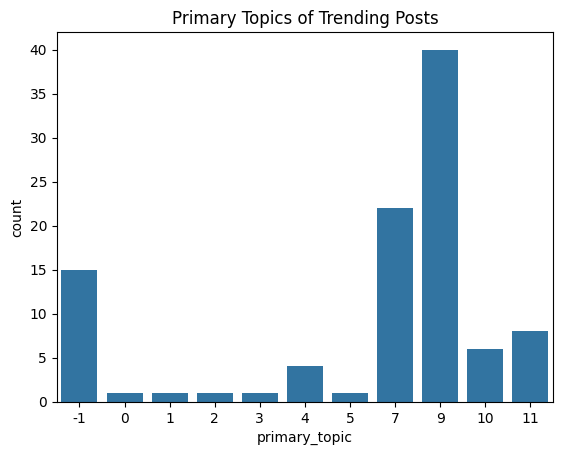

In [ ]:
sns.countplot(x='primary_topic', data=top_trends)
plt.title('Primary Topics of Trending Posts')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       330
           1       1.00      1.00      1.00        74

    accuracy                           1.00       404
   macro avg       1.00      1.00      1.00       404
weighted avg       1.00      1.00      1.00       404


ROC AUC Score: 1.0000


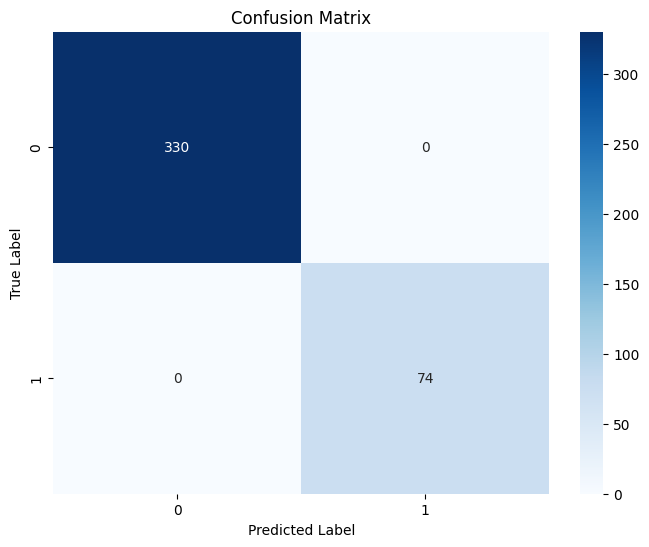

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_model_evaluation(model, X_test, y_test, feature_names):
    """
    Comprehensive evaluation of trend detection model
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Classification metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # ROC AUC
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC AUC Score: {auc_score:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Feature importance (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        feature_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 8))
        sns.barplot(data=feature_imp.head(20), x='importance', y='feature')
        plt.title('Top 20 Feature Importances')
        plt.tight_layout()
        plt.show()
    
    return {
        'auc': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

# Evaluate the ensemble model
X_features, feature_names = trend_ensemble.prepare_features(df_posts)
train_size = int(0.8 * len(X_features))
X_test = X_features[train_size:]
y_test = df_posts['is_trending'].iloc[train_size:]

evaluation_results = comprehensive_model_evaluation(
    trained_model, X_test, y_test, feature_names
)


In [ ]:
import re


def extract_hashtags(text):
    """Extract hashtags from text"""
    if pd.isna(text):
        return []
    hashtags = re.findall(r'#\w+', text.lower())
    return [tag.replace('#', '') for tag in hashtags]


In [ ]:
# Extract hashtags
df['hashtag_list'] = df['text'].apply(extract_hashtags)
df['hashtag_text'] = df['hashtag_list'].apply(lambda x: ' '.join(x))

In [ ]:
df.columns

Index(['post_id', 'text', 'transcribed_text', 'video_description',
       'textLanguage', 'detected_language', 'createTimeISO', 'isAd',
       'isSponsored', 'video_duration', 'date', 'author_nickName',
       'author_signature', 'author_fans', 'diggCount', 'shareCount',
       'playCount', 'collectCount', 'commentCount', 'searchHashtag_name',
       'searchHashtag_views', 'location_address', 'all_comments_text',
       'total_comments', 'first_comment_time', 'last_comment_time',
       'total_comment_likes', 'avg_comment_likes', 'max_comment_likes',
       'total_comment_replies', 'avg_comment_replies', 'unique_commenters',
       'comment_languages', 'comment_entries_count', 'hashtag_list',
       'hashtag_text'],
      dtype='object')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def create_tfidf_features(text_series, max_features=5000, ngram_range=(1,2)):
    """
    Create TF-IDF features for text data
    """
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=2,
        max_df=0.95,
        strip_accents='unicode',
        lowercase=True
    )

    tfidf_matrix = vectorizer.fit_transform(text_series.fillna(''))
    feature_names = vectorizer.get_feature_names_out()

    return tfidf_matrix, vectorizer, feature_names

# Create TF-IDF features for different text types
transcript_tfidf, transcript_vectorizer, transcript_features = create_tfidf_features(df['transcribed_text'])
comments_tfidf, comments_vectorizer, comments_features = create_tfidf_features(df['all_comments_text'])
captions_tfidf, captions_vectorizer, captions_features = create_tfidf_features(df['text'])
hashtag_tfidf, hashtag_vectorizer, hashtag_features = create_tfidf_features(df['hashtag_text'])

In [ ]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np

def create_word2vec_embeddings(text_series, vector_size=100, window=5, min_count=2):
    """
    Create Word2Vec embeddings
    """
    # Prepare sentences for Word2Vec
    sentences = [simple_preprocess(text) for text in text_series.fillna('') if text.strip()]
    
    # Train Word2Vec model
    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=4,
        epochs=10
    )
    
    return model

def text_to_vector(text, model, vector_size=100):
    """
    Convert text to average word vector
    """
    words = simple_preprocess(text)
    word_vectors = []
    
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Create Word2Vec embeddings
combined_text = pd.concat([
    df['transcribed_text'], 
    df['comment'], 
    df['text']
]).dropna()

word2vec_model = create_word2vec_embeddings(combined_text)

# Generate document vectors
df['transcript_w2v'] = df['transcribed_text'].apply(
    lambda x: text_to_vector(x, word2vec_model) if pd.notna(x) else np.zeros(100)
)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

def create_bert_embeddings(texts, model_name='bert-base-uncased', max_length=512):
    """
    Create BERT embeddings for text data
    """
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name, output_hidden_states=True)
    model.eval()
    
    embeddings = []
    
    with torch.no_grad():
        for text in texts:
            if pd.isna(text) or text.strip() == '':
                embeddings.append(np.zeros(768))  # BERT base has 768 dimensions
                continue
                
            # Tokenize and encode
            encoded = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            # Get BERT embeddings
            outputs = model(**encoded)
            
            # Use [CLS] token embedding as document representation
            cls_embedding = outputs.last_hidden_state[0][0].numpy()
            embeddings.append(cls_embedding)
    
    return np.array(embeddings)

# Create BERT embeddings (use smaller batches to manage memory)
batch_size = 32
bert_embeddings = []

for i in range(0, len(df), batch_size):
    batch_texts = df['transcribed_text'][i:i+batch_size].tolist()
    batch_embeddings = create_bert_embeddings(batch_texts)
    bert_embeddings.extend(batch_embeddings)

df['bert_embeddings'] = list(bert_embeddings)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

KeyboardInterrupt: 